### Import packages

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from pathlib import Path
from scipy.ndimage import generic_filter
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import warnings
import numpy as np
from scipy.stats import norm
import os
import pathlib
warnings.filterwarnings("ignore")

### Define paths

In [4]:
# base paths
base = pathlib.Path().resolve()
data = base / "Data"
result = base / "result"
# paths for training data
periods = {
    "2000_2010": {
        "raster_dir": data / "Bio_oracle" / "2000_2010" / "Mean_Cropped",
        "rhodolith_train": data / "Corallinales" / "gbif_corallinales_all_20250405" / "corallinales_2000_2010_deduplicated.gpkg",
        "rhodolith_test": data / "Corallinales" / "gbif_corallinales_all_20250405" / "corallinales_2000_2010.gpkg",
        "pseudo_train": data / "Pseudo_absence" / "Combined" / "Balanced" / "pseudo_absence_balanced_2000_2010.gpkg",
        "pseudo_test": data / "Pseudo_absence" / "Combined" / "comb_2000_2010.gpkg"
    },
    "2010_2020": {
        "raster_dir": data / "Bio_oracle" / "2010_2020" / "Mean_Cropped",
        "rhodolith_train": data / "Corallinales" / "gbif_corallinales_all_20250405" / "corallinales_2010_onward_deduplicated.gpkg",
        "rhodolith_test": data / "Corallinales" / "gbif_corallinales_all_20250405" / "corallinales_2010_onward.gpkg",
        "pseudo_train": data / "Pseudo_absence" / "Combined" / "Balanced" / "pseudo_absence_balanced_2010_onward.gpkg",
        "pseudo_test": data / "Pseudo_absence" / "Combined" / "comb_2010_onward.gpkg"
    }
}

# Data for future prediction

future_periods = {
    "2010_2020": data / "Bio_oracle" / "2010_2020" / "Mean_Cropped",
    "2020_2030": data / "Bio_oracle" / "2020_2030" / "Mean_Cropped",
    "2030_2040": data / "Bio_oracle" / "2030_2040" / "Mean_Cropped",
    "2040_2050": data / "Bio_oracle" / "2040_2050" / "Mean_Cropped",
    "2050_2060": data / "Bio_oracle" / "2050_2060" / "Mean_Cropped",
    "2060_2070": data / "Bio_oracle" / "2060_2070" / "Mean_Cropped",
    "2070_2080": data / "Bio_oracle" / "2070_2080" / "Mean_Cropped",
    "2080_2090": data / "Bio_oracle" / "2080_2090" / "Mean_Cropped",
    "2090_2100": data / "Bio_oracle" / "2090_2100" / "Mean_Cropped"
}

fallback_dir = data / "Bio_oracle" / "2010_2020" / "Mean_Cropped"

### Model training and evalution


Loading TRAINING data for 2000_2010 (deduplicated)
Loading TEST data for 2000_2010 (full set)

Loading TRAINING data for 2010_2020 (deduplicated)
Loading TEST data for 2010_2020 (full set)

Final training size: 651
  Training presences: 327
  Training absences:  324
Final test size (after removing overlaps): 2039
  Test presences: 908
  Test absences:  1131

🔍 Random Forest
Accuracy: 0.9176066699362433
ROC AUC: 0.9539134406026399
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1131
           1       0.85      0.99      0.91       908

    accuracy                           0.92      2039
   macro avg       0.92      0.92      0.92      2039
weighted avg       0.93      0.92      0.92      2039



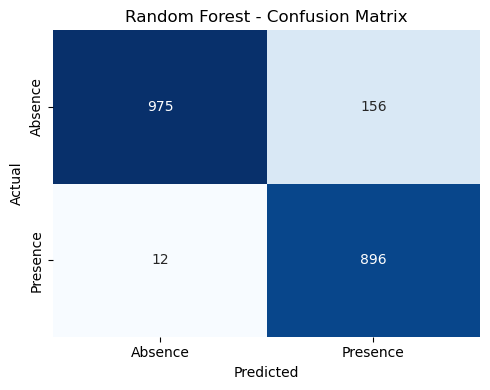


 Random Forest - Feature Importances
    Feature  Importance
5       no3    0.272891
7        ph    0.155661
6     kdpar    0.149025
4    thetao    0.087270
1       clt    0.082282
0       chl    0.072436
2       dfe    0.068726
3        o2    0.031036
8       sws    0.029722
10  terrain    0.028530
9       swd    0.022422


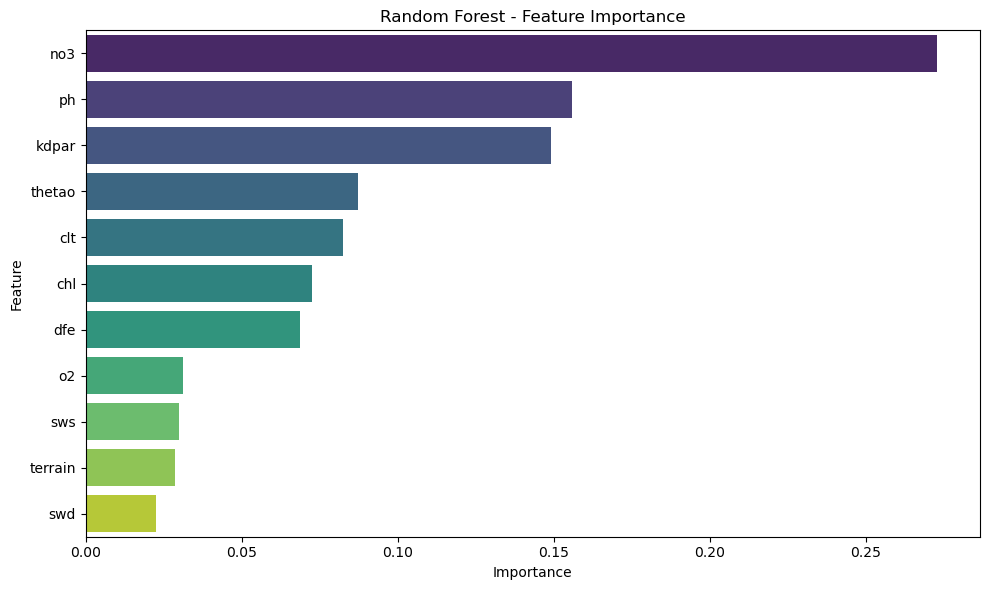


🔍 Logistic Regression
Accuracy: 0.8734673859735165
ROC AUC: 0.9116230812076171
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1131
           1       0.80      0.94      0.87       908

    accuracy                           0.87      2039
   macro avg       0.88      0.88      0.87      2039
weighted avg       0.88      0.87      0.87      2039



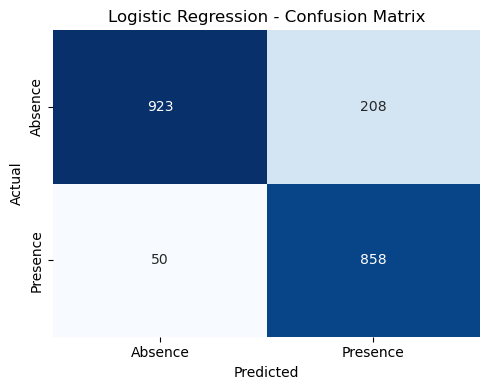


 Logistic Regression - Coefficients
    Feature  Coefficient
6     kdpar    -4.465080
0       chl    -2.849568
1       clt     2.242328
7        ph     1.226919
8       sws     0.955530
5       no3     0.775727
4    thetao     0.276413
2       dfe    -0.028245
10  terrain    -0.013921
3        o2     0.001270
9       swd    -0.000604


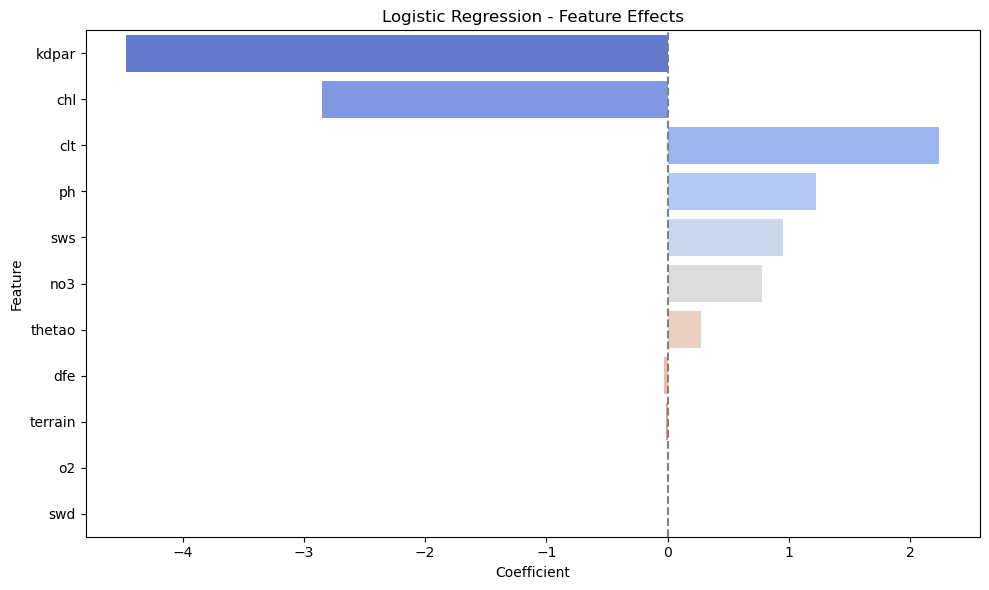


🔍 XGBoost
Accuracy: 0.9136831780284453
ROC AUC: 0.9531412496056276
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1131
           1       0.86      0.97      0.91       908

    accuracy                           0.91      2039
   macro avg       0.91      0.92      0.91      2039
weighted avg       0.92      0.91      0.91      2039



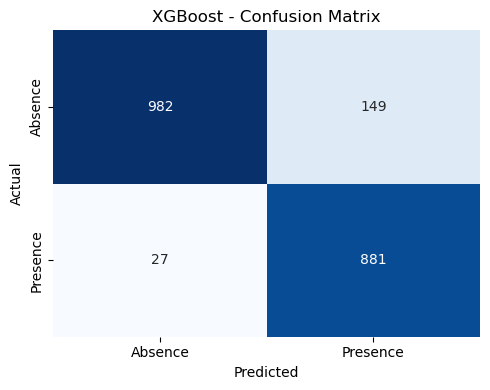


 XGBoost - Feature Importances
    Feature  Importance
5       no3    0.371586
3        o2    0.330269
7        ph    0.098280
1       clt    0.035861
2       dfe    0.033958
4    thetao    0.026672
10  terrain    0.023306
6     kdpar    0.021538
0       chl    0.021183
8       sws    0.021171
9       swd    0.016176


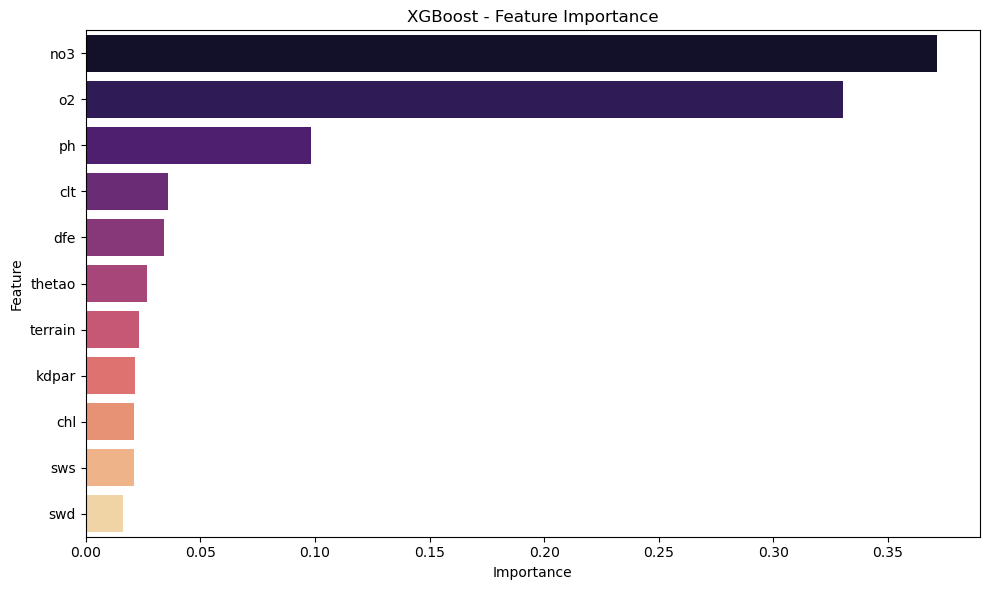


 Ensemble Model
Accuracy: 0.9156449239823443
ROC AUC: 0.9528724920833381
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1131
           1       0.85      0.99      0.91       908

    accuracy                           0.92      2039
   macro avg       0.92      0.92      0.92      2039
weighted avg       0.93      0.92      0.92      2039



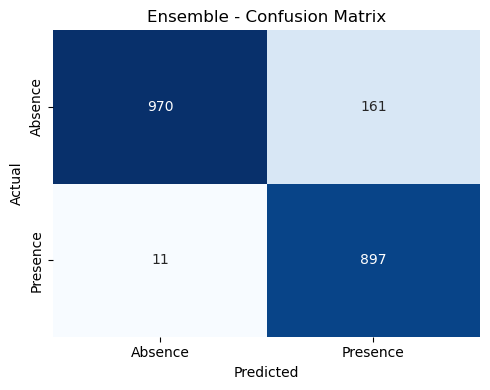

In [6]:
# Define environmental variables to extract from raster files
selected_vars = ["chl", "clt", "dfe", "o2", "thetao", "no3", "kdpar", "ph", "sws", "swd", "terrain"]

# Fill missing values in raster array using the mean of surrounding cells
def fill_nan_with_mean(array, size=5):
    def replace_nan_with_mean(values):
        center = values[len(values) // 2]
        if np.isnan(center):  # only replace if the center is NaN
            valid = values[~np.isnan(values)]
            return valid.mean() if len(valid) > 0 else np.nan
        return center
    return generic_filter(array, replace_nan_with_mean, size=size, mode='nearest')

# Extract environmental variable values from raster stack at point locations
def extract_raster_values(gdf, raster_dir, variables, fill_nodata=True):
    gdf = gdf.copy()
    coords = [(geom.x, geom.y) for geom in gdf.geometry]  # extract lon, lat for each point

    for var in variables:
        with rasterio.open(raster_dir / f"{var}.tif") as src:
            # Sample values at point locations
            vals = [val[0] if val[0] != src.nodata else np.nan for val in src.sample(coords)]
            vals = np.array(vals, dtype="float32")

            # Optionally fill missing values using local smoothing
            if fill_nodata and np.any(np.isnan(vals)):
                full = src.read(1).astype("float32")
                if src.nodata is not None:
                    full[full == src.nodata] = np.nan
                filled = fill_nan_with_mean(full)

                # Re-sample filled array for missing points
                interp_vals = []
                for x, y in coords:
                    try:
                        row, col = src.index(x, y)
                        row = np.clip(row, 0, filled.shape[0] - 1)
                        col = np.clip(col, 0, filled.shape[1] - 1)
                        interp_vals.append(filled[row, col])
                    except:
                        interp_vals.append(np.nan)
                vals = np.where(np.isnan(vals), interp_vals, vals)

            gdf[var] = vals  # assign extracted/filled values to the GeoDataFrame

    return gdf

# Prepare training and test data by extracting raster values
train_dfs = []
test_dfs = []

for period, info in periods.items():
    print(f"\nLoading TRAINING data for {period} (deduplicated)")
    train_presence = gpd.read_file(info["rhodolith_train"])
    train_pseudo = gpd.read_file(info["pseudo_train"])
    train_presence["label"] = 1  # label for presence
    train_pseudo["label"] = 0  # label for pseudo-absence
    train_df = pd.concat([train_presence, train_pseudo], ignore_index=True)

    train_df = extract_raster_values(train_df, info["raster_dir"], selected_vars)  # sample raster data
    train_df["period"] = period
    train_dfs.append(train_df)

    print(f"Loading TEST data for {period} (full set)")
    test_presence = gpd.read_file(info["rhodolith_test"])
    test_pseudo = gpd.read_file(info["pseudo_test"])
    test_presence["label"] = 1
    test_pseudo["label"] = 0
    test_df = pd.concat([test_presence, test_pseudo], ignore_index=True)

    test_df = extract_raster_values(test_df, info["raster_dir"], selected_vars)
    test_df["period"] = period
    test_dfs.append(test_df)

# Merge all time periods into one combined train and test set
combined_train = pd.concat(train_dfs, ignore_index=True)
combined_test = pd.concat(test_dfs, ignore_index=True)

# Remove test points that overlap with training data (based on rounded coordinates)
train_coords = set(zip(combined_train.geometry.x.round(6), combined_train.geometry.y.round(6)))
mask = ~combined_test.apply(lambda row: (round(row.geometry.x, 6), round(row.geometry.y, 6)) in train_coords, axis=1)
combined_test = combined_test[mask].copy()

# Separate features and labels
X_train = combined_train[selected_vars]
y_train = combined_train["label"]
X_test = combined_test[selected_vars]
y_test = combined_test["label"]

# Drop any rows with missing values before training
train_valid = X_train.dropna()
y_train_valid = y_train.loc[train_valid.index]
test_valid = X_test.dropna()
y_test_valid = y_test.loc[test_valid.index]

# Print final dataset size statistics
print(f"\nFinal training size: {len(train_valid)}")
print(f"  Training presences: {sum(y_train_valid == 1)}")
print(f"  Training absences:  {sum(y_train_valid == 0)}")
print(f"Final test size (after removing overlaps): {len(test_valid)}")
print(f"  Test presences: {sum(y_test_valid == 1)}")
print(f"  Test absences:  {sum(y_test_valid == 0)}")

# Define machine learning models to test
models = {
    "Random Forest": RandomForestClassifier(n_estimators=250, max_depth=5, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🔍 {name}")
    model.fit(train_valid, y_train_valid)
    y_pred = model.predict(test_valid)
    y_proba = model.predict_proba(test_valid)[:, 1]

    print("Accuracy:", accuracy_score(y_test_valid, y_pred))
    print("ROC AUC:", roc_auc_score(y_test_valid, y_proba))
    print(classification_report(y_test_valid, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_valid, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Absence", "Presence"], yticklabels=["Absence", "Presence"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Plot feature importances or coefficients depending on model type
    if name == "Random Forest":
        importances = model.feature_importances_
        fi_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances}).sort_values(by="Importance", ascending=False)
        print("\n Random Forest - Feature Importances")
        print(fi_df)
        plt.figure(figsize=(10, 6))
        sns.barplot(data=fi_df, x="Importance", y="Feature", palette="viridis")
        plt.title("Random Forest - Feature Importance")
        plt.tight_layout()
        plt.show()

    elif name == "XGBoost":
        importances = model.feature_importances_
        fi_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances}).sort_values(by="Importance", ascending=False)
        print("\n XGBoost - Feature Importances")
        print(fi_df)
        plt.figure(figsize=(10, 6))
        sns.barplot(data=fi_df, x="Importance", y="Feature", palette="magma")
        plt.title("XGBoost - Feature Importance")
        plt.tight_layout()
        plt.show()

    elif name == "Logistic Regression":
        coef = model.coef_[0]
        fi_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": coef}).sort_values(by="Coefficient", key=abs, ascending=False)
        print("\n Logistic Regression - Coefficients")
        print(fi_df)
        plt.figure(figsize=(10, 6))
        sns.barplot(data=fi_df, x="Coefficient", y="Feature", palette="coolwarm")
        plt.axvline(0, linestyle='--', color='gray')
        plt.title("Logistic Regression - Feature Effects")
        plt.tight_layout()
        plt.show()

# Train and evaluate ensemble model using soft voting
ensemble = VotingClassifier(estimators=[
    ('rf', models["Random Forest"]),
    ('lr', models["Logistic Regression"]),
    ('xgb', models["XGBoost"])
], voting='soft')

ensemble.fit(train_valid, y_train_valid)
y_pred_ens = ensemble.predict(test_valid)
y_proba_ens = ensemble.predict_proba(test_valid)[:, 1]

print("\n Ensemble Model")
print("Accuracy:", accuracy_score(y_test_valid, y_pred_ens))
print("ROC AUC:", roc_auc_score(y_test_valid, y_proba_ens))
print("Classification Report:\n", classification_report(y_test_valid, y_pred_ens))

# Plot ensemble confusion matrix
cm_ens = confusion_matrix(y_test_valid, y_pred_ens)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Absence", "Presence"], yticklabels=["Absence", "Presence"])
plt.title("Ensemble - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



#### Delong test

In [7]:
# Prepare true labels and predicted probabilities for comparison
y_true = y_test_valid.values  # extract true labels from test set

# Get predicted probabilities from each model (for the positive class)
probas = {
    "Random Forest": models["Random Forest"].predict_proba(test_valid)[:, 1],
    "Logistic Regression": models["Logistic Regression"].predict_proba(test_valid)[:, 1],
    "XGBoost": models["XGBoost"].predict_proba(test_valid)[:, 1],
    "Ensemble": ensemble.predict_proba(test_valid)[:, 1]
}

# Function to perform DeLong test for AUC comparison between two classifiers
def delong_roc_test(y_true, y_scores1, y_scores2):
    # Compute midrank for tied score handling
    def compute_midrank(x):
        J = np.argsort(x)
        Z = x[J]
        N = len(x)
        T = np.zeros(N, dtype=float)
        i = 0
        while i < N:
            j = i
            while j < N and Z[j] == Z[i]:
                j += 1
            T[i:j] = 0.5 * (i + j - 1)  # average rank for ties
            i = j
        T2 = np.empty(N)
        T2[J] = T + 1  # shift ranks to be 1-based
        return T2

    # Calculate AUC and its variance for a single model
    def calc_auc_var(y_true, y_scores):
        pos = y_scores[y_true == 1]
        neg = y_scores[y_true == 0]
        n_pos = len(pos)
        n_neg = len(neg)
        all_scores = np.concatenate((pos, neg))
        all_ranks = compute_midrank(all_scores)
        pos_ranks = all_ranks[:n_pos]
        auc = (pos_ranks - 1).sum() / (n_pos * n_neg) - (n_pos + 1) / (2 * n_neg)
        var = auc * (1 - auc) / min(n_pos, n_neg)
        return auc, var

    # Compute AUCs and variances for both models
    auc1, var1 = calc_auc_var(y_true, y_scores1)
    auc2, var2 = calc_auc_var(y_true, y_scores2)

    # Compute standard error and test statistic
    se_diff = np.sqrt(var1 + var2)
    z_score = (auc1 - auc2) / se_diff
    p_value = 2 * norm.sf(abs(z_score))  # two-sided test

    return auc1, auc2, z_score, p_value

# Compare ensemble model against all individual models
ensemble_proba = probas["Ensemble"]  # store ensemble predictions

for model_name, proba in probas.items():
    if model_name == "Ensemble":
        continue  # skip comparison with itself

    # Perform DeLong test between ensemble and current model
    auc_ens, auc_model, z, p = delong_roc_test(y_true, ensemble_proba, proba)

    # Report AUC scores and statistical comparison
    print(f"\nEnsemble vs {model_name}")
    print(f"AUC Ensemble: {auc_ens:.4f}, AUC {model_name}: {auc_model:.4f}")
    print(f"Z-score: {z:.4f}, p-value: {p:.4f}")

    if p < 0.05:
        print("→ Statistically significant difference.")
    else:
        print("→ No significant difference.")


Ensemble vs Random Forest
AUC Ensemble: 0.9520, AUC Random Forest: 0.9530
Z-score: -0.1043, p-value: 0.9169
→ No significant difference.

Ensemble vs Logistic Regression
AUC Ensemble: 0.9520, AUC Logistic Regression: 0.9107
Z-score: 3.4879, p-value: 0.0005
→ Statistically significant difference.

Ensemble vs XGBoost
AUC Ensemble: 0.9520, AUC XGBoost: 0.9523
Z-score: -0.0268, p-value: 0.9786
→ No significant difference.


### Predictions

In [8]:
from copy import deepcopy

# Function to stack raster layers for a given set of variables
# Falls back to another directory if a raster is missing
def stack_rasters_with_fallback(primary_dir, fallback_dir, variables):
    layers = []  # list to store raster bands
    meta = None  # to store metadata for writing

    for var in variables:
        raster_path = primary_dir / f"{var}.tif"  # check in primary directory

        # Use fallback raster if not found
        if not raster_path.exists():
            print(f" {var}.tif not found in {primary_dir.name}, using fallback from {fallback_dir.name}")
            raster_path = fallback_dir / f"{var}.tif"

        # Open and process the raster
        with rasterio.open(raster_path) as src:
            if meta is None:
                meta = src.meta.copy()
                meta.update(count=len(variables), dtype='float32')  # update metadata for stacked output

            data = src.read(1).astype('float32')  # read raster band
            if src.nodata is not None:
                data[data == src.nodata] = np.nan  # convert NoData to NaN

            filled = fill_nan_with_mean(data)  # fill missing pixels
            layers.append(filled)  # store processed layer

    return np.stack(layers), meta  # return stacked array and metadata

# Function to apply trained classifier to a stacked raster
def predict_raster(model, stacked_array):
    bands, height, width = stacked_array.shape  # extract dimensions
    flat = stacked_array.reshape(bands, -1).T  # flatten for prediction (pixels × bands)

    mask = np.any(np.isnan(flat), axis=1)  # identify rows with missing values
    valid = flat[~mask]  # keep only valid rows

    preds = model.predict_proba(valid)[:, 1]  # predict probability of class 1
    result = np.full(flat.shape[0], np.nan)  # initialize full result array with NaNs
    result[~mask] = preds  # insert predictions

    return result.reshape(height, width)  # reshape to raster format

# Function to save prediction array as a GeoTIFF
def save_raster(pred_array, meta, out_path):
    meta.update(count=1, dtype='float32')  # set single-band float32 output
    with rasterio.open(out_path, 'w', **meta) as dst:
        dst.write(pred_array.astype('float32'), 1)  # write prediction to disk

# Predict rhodolith suitability for each future scenario
for future_label, future_dir in future_periods.items():
    print(f"\n Predicting for {future_label}")

    # Stack environmental rasters (using fallback where needed)
    stacked, meta = stack_rasters_with_fallback(future_dir, fallback_dir, selected_vars)

    # Generate prediction raster using ensemble model
    pred = predict_raster(ensemble, stacked)

    # Apply a simple terrain mask to exclude shallow or invalid areas
    terrain_path = fallback_dir / "terrain.tif"
    if terrain_path.exists():
        with rasterio.open(terrain_path) as terrain_src:
            terrain = terrain_src.read(1)
            mask_invalid = (terrain > -50) | (terrain >= 0) | np.isnan(terrain)  # exclude depths shallower than -50m
            pred[mask_invalid] = 0  # set as unsuitable

    # Save the prediction raster
    out_file = base / f"rhodolith_prediction_{future_label}.tif"
    save_raster(pred, meta, out_file)
    print(f" Saved {future_label} prediction to {out_file}")



 Predicting for 2010_2020
 Saved 2010_2020 prediction to C:\Users\rasmu\Desktop\Universitet\Maerl\rhodolith_prediction_2010_2020.tif

 Predicting for 2020_2030
 kdpar.tif not found in Mean_Cropped, using fallback from Mean_Cropped
 terrain.tif not found in Mean_Cropped, using fallback from Mean_Cropped
 Saved 2020_2030 prediction to C:\Users\rasmu\Desktop\Universitet\Maerl\rhodolith_prediction_2020_2030.tif

 Predicting for 2030_2040
 kdpar.tif not found in Mean_Cropped, using fallback from Mean_Cropped
 terrain.tif not found in Mean_Cropped, using fallback from Mean_Cropped
 Saved 2030_2040 prediction to C:\Users\rasmu\Desktop\Universitet\Maerl\rhodolith_prediction_2030_2040.tif

 Predicting for 2040_2050
 kdpar.tif not found in Mean_Cropped, using fallback from Mean_Cropped
 terrain.tif not found in Mean_Cropped, using fallback from Mean_Cropped
 Saved 2040_2050 prediction to C:\Users\rasmu\Desktop\Universitet\Maerl\rhodolith_prediction_2040_2050.tif

 Predicting for 2050_2060
 kdpa